In [1]:
from datetime import datetime
import pandas as pd

import os
from tqdm import tqdm 

import missingno as msno

## import helper

In [2]:
from config_GAM2025 import gam_info

import test_functions 

In [3]:
# country
cols = ['Podcast (Redshift raw data)','PlaceID', 'CBC_country']
country_codes = pd.read_excel(f"../../{gam_info['lookup_file']}", sheet_name='CountryID')[cols]
country_codes = country_codes.rename(columns={'Podcast (Redshift raw data)': 'country', 
                                              'PlaceID': 'PlaceID'})

# week 
cols = ['w/c', 'YearGAE']
week_tester = pd.read_excel(f"../../{gam_info['lookup_file']}", sheet_name='GAM Period')[cols]
week_tester['w/c'] = pd.to_datetime(week_tester['w/c'])

# service details
service_details = pd.read_excel(f"../../{gam_info['lookup_file']}", 
                                     sheet_name='ServiceID').dropna(how='all')
cols = ['ServiceID', 'service']
service_details = service_details.rename(columns={'Podcast': 'service'})[cols]

# podcast details
podcast_details = pd.read_excel(f"../../{gam_info['lookup_file']}", 
                                     sheet_name='Podcast').dropna(how='all')
podcast_details.sample()

# platform codes
platform_codes = pd.read_excel(f"../../{gam_info['lookup_file']}", sheet_name='PlatformID')#[cols]


# processing

<Axes: >

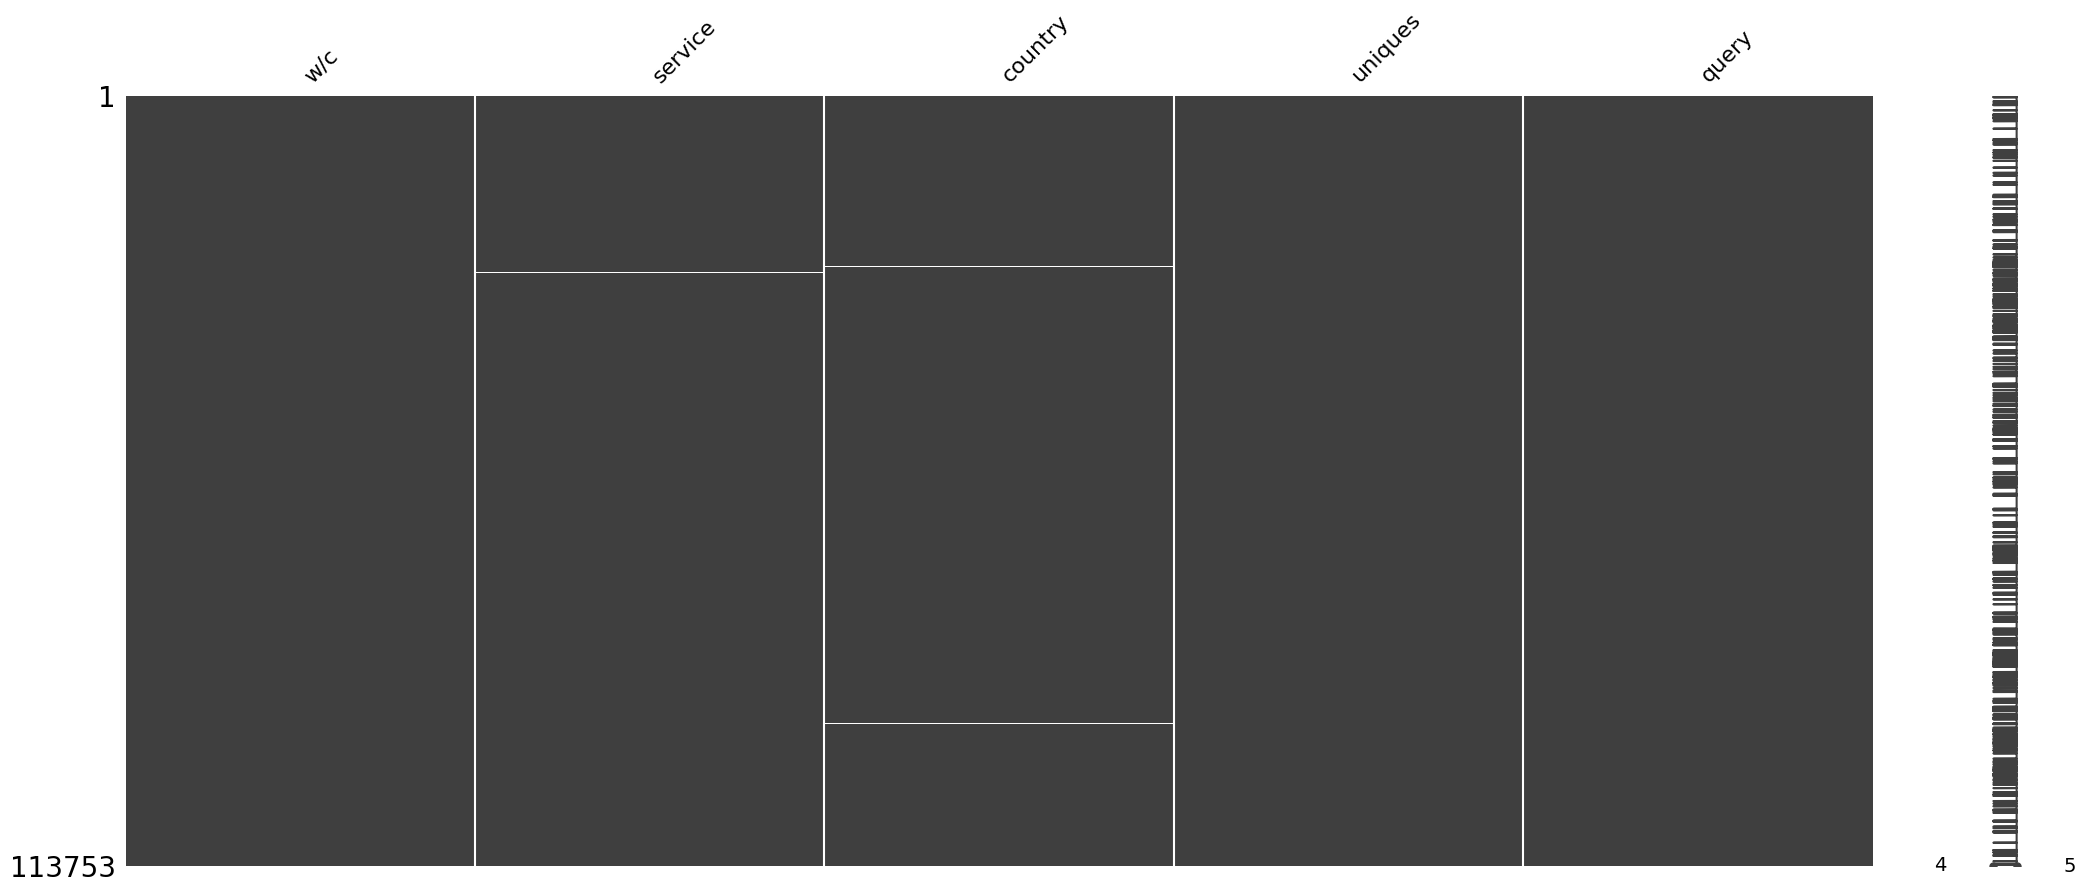

In [4]:
# Initialize an empty list to store DataFrames
temp_dfs = []

# Define the directory containing the files
directory = '../data/raw/podcast'

# Iterate over each file in the directory
for filename in os.listdir(directory):
    # Check if the filename matches the required condition
    if filename.split('_')[0] == gam_info['file_timeinfo']:
        # Check if 'test_finding_all' is not in the filename
        if 'test_finding_all' not in filename:
            # Read the file into a DataFrame
            file_path = os.path.join(directory, filename)
            temp = pd.read_csv(file_path).rename(columns={'week': 'w/c'})
            # Add a 'query' column to the DataFrame based on filename
            temp['query'] = filename.split('_')[2]
            
            # Append the DataFrame to the list
            temp_dfs.append(temp)

# Concatenate all DataFrames in the list into a single DataFrame
df_raw = pd.concat(temp_dfs, ignore_index=True).drop(columns=['old_uniques', 'downloads'])
df_raw['w/c'] = pd.to_datetime(df_raw['w/c'])
# Display the concatenated DataFrame
df_raw.sample()
msno.matrix(df_raw)

..weeks:
All weeks are present in the dataset.
...updating logbook...



,w/c,service,country,uniques,query,PlatformID,YearGAE
16592,2024-07-15,* BBC World Service,vi,67,totalWS,DPO,2025


..services:
Inner join test 2_POD_2 successful: No issues found.
...updating logbook...



,w/c,country,uniques,query,PlatformID,YearGAE,ServiceID
308,2024-11-18,uy,1067,totalWS,DPO,2025,ANW


..countries:
Inner join test 2_POD_3 successful: No issues found.
...updating logbook...



,w/c,uniques,query,PlatformID,YearGAE,ServiceID,PlaceID
23151,2024-08-05,4171,totalWS,DPO,2025,UKPS,INO


<Axes: >

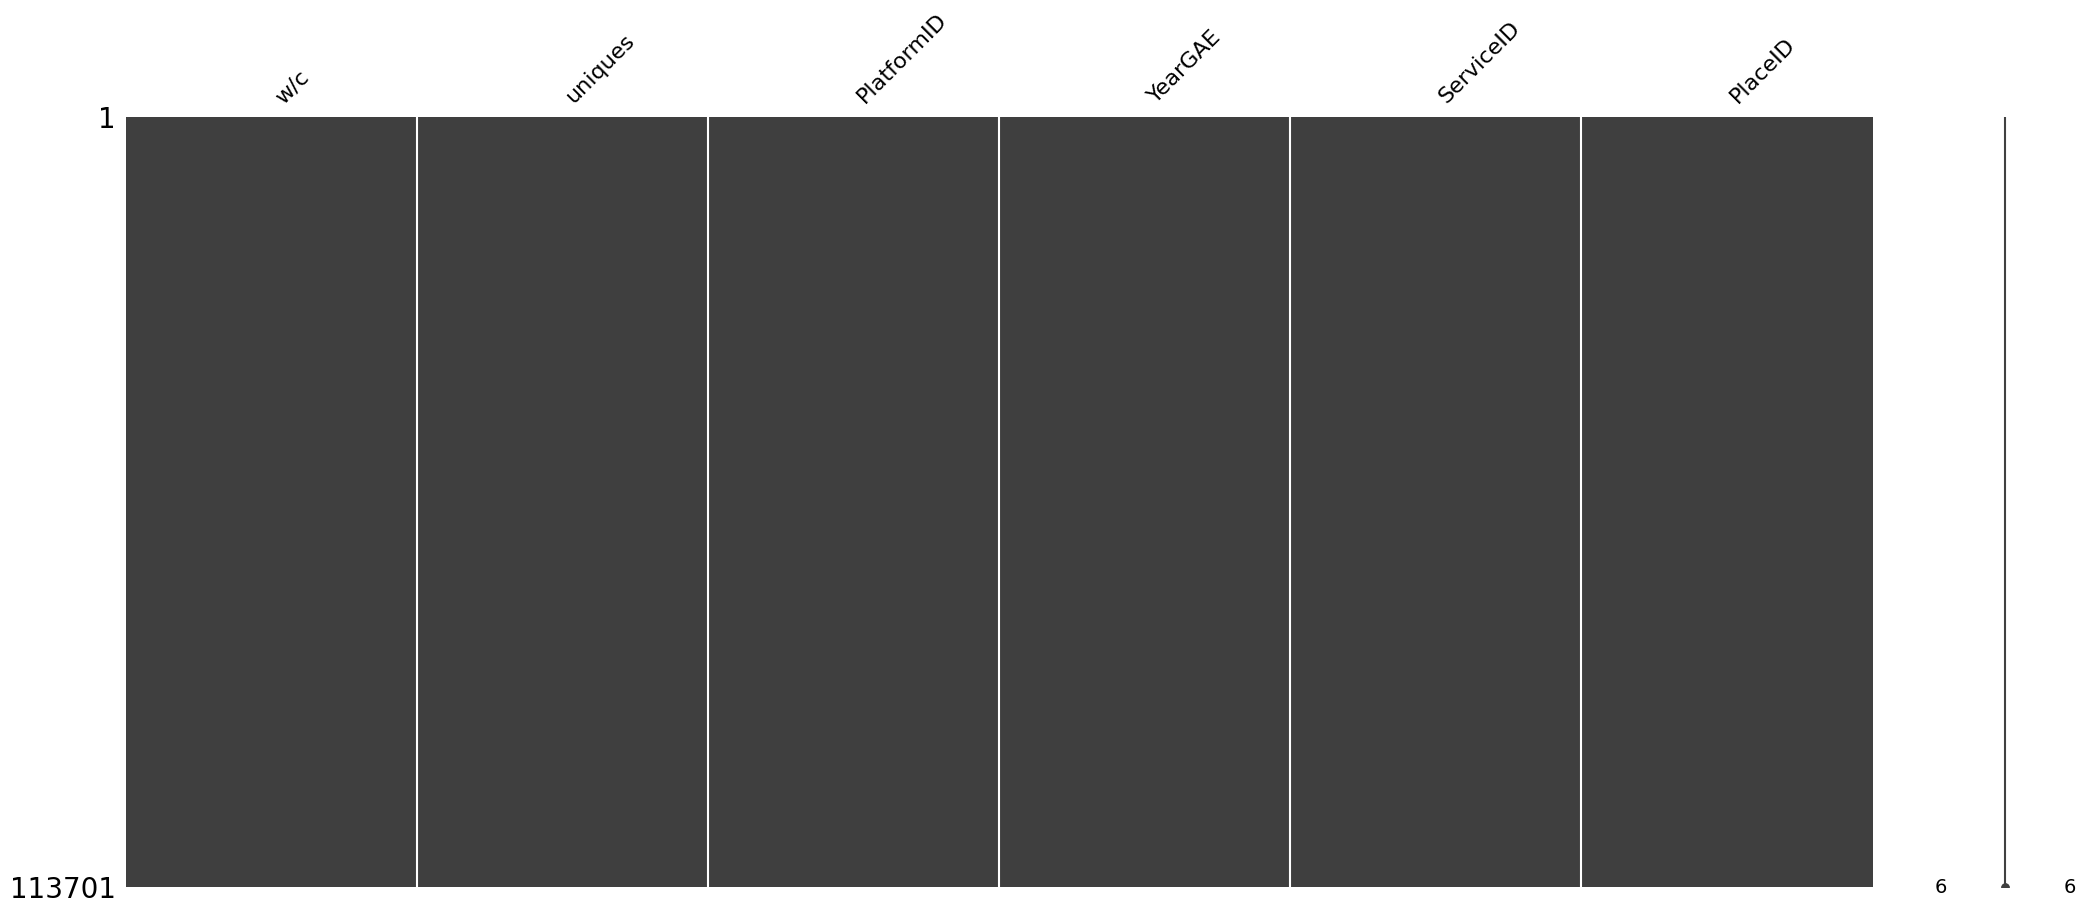

In [5]:
test_step="reading in all sql queries"

df_raw['PlatformID'] = 'DPO'

# test & add weeks
print('..weeks:')
test_functions.test_weeks_presence('w/c', df_raw, week_tester, '2_POD_1', test_step)

df = df_raw.merge(week_tester, on='w/c', how='left') #left because this test has run and I NEVER want to loose data
display(df.sample())


# test & add services
print('..services:')
# if Na values and query is allBBC then they can be safely excluded 
df = df.dropna(subset='service')
test_functions.test_inner_join(df, service_details[['ServiceID', 'service']].dropna(), ['service'], '2_POD_2', test_step, focus='left') 

df = df.merge(service_details, on='service', how='left').drop(columns='service') #left because this test has run and I NEVER want to loose data
display(df.sample())

# test & add countries
print('..countries:')
cols = ['country','PlaceID', ]
test_functions.test_inner_join(df, country_codes[cols], ['country'], '2_POD_3', test_step, focus='left')

df = df.merge(country_codes[cols], on='country', how='left').drop(columns='country') #left because this test has run and I NEVER want to loose data
display(df.sample())

df.drop(columns='query', inplace=True)

msno.matrix(df)

# IPO data

,w/c,CBC_country,uniques
4734,2025-02-17,Somalia,14


..weeks:
All weeks are present in the dataset.
...updating logbook...

..countries:
Inner join test 2_POD_5 successful: No issues found.
...updating logbook...



,YearGAE,uniques,PlatformID,PlaceID,ServiceID,w/c
48,2025,75388,IPO,USA,WSE,2025-03-03


All weeks are present in the dataset.
...updating logbook...

2_POD_7: ALL: (5969, 6)
passed the test! 
...updating logbook...

2_POD_8: ANW: (5969, 6)
passed the test! 
...updating logbook...



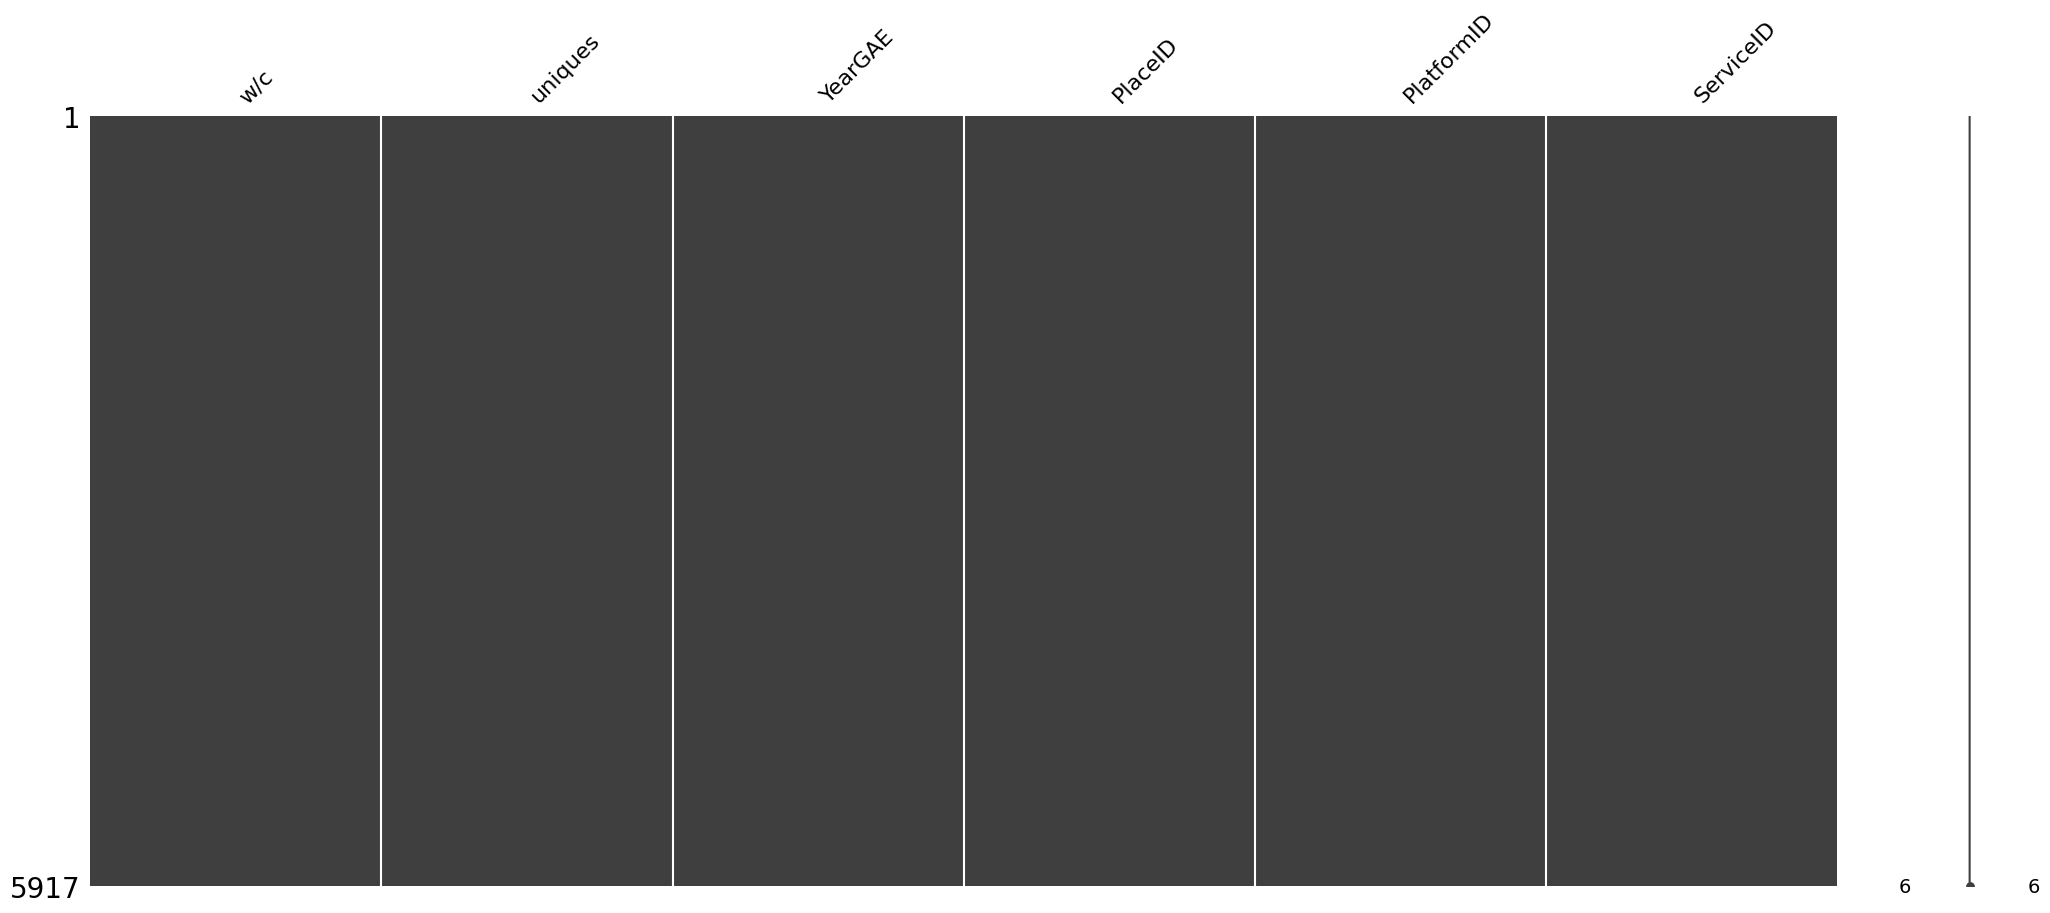

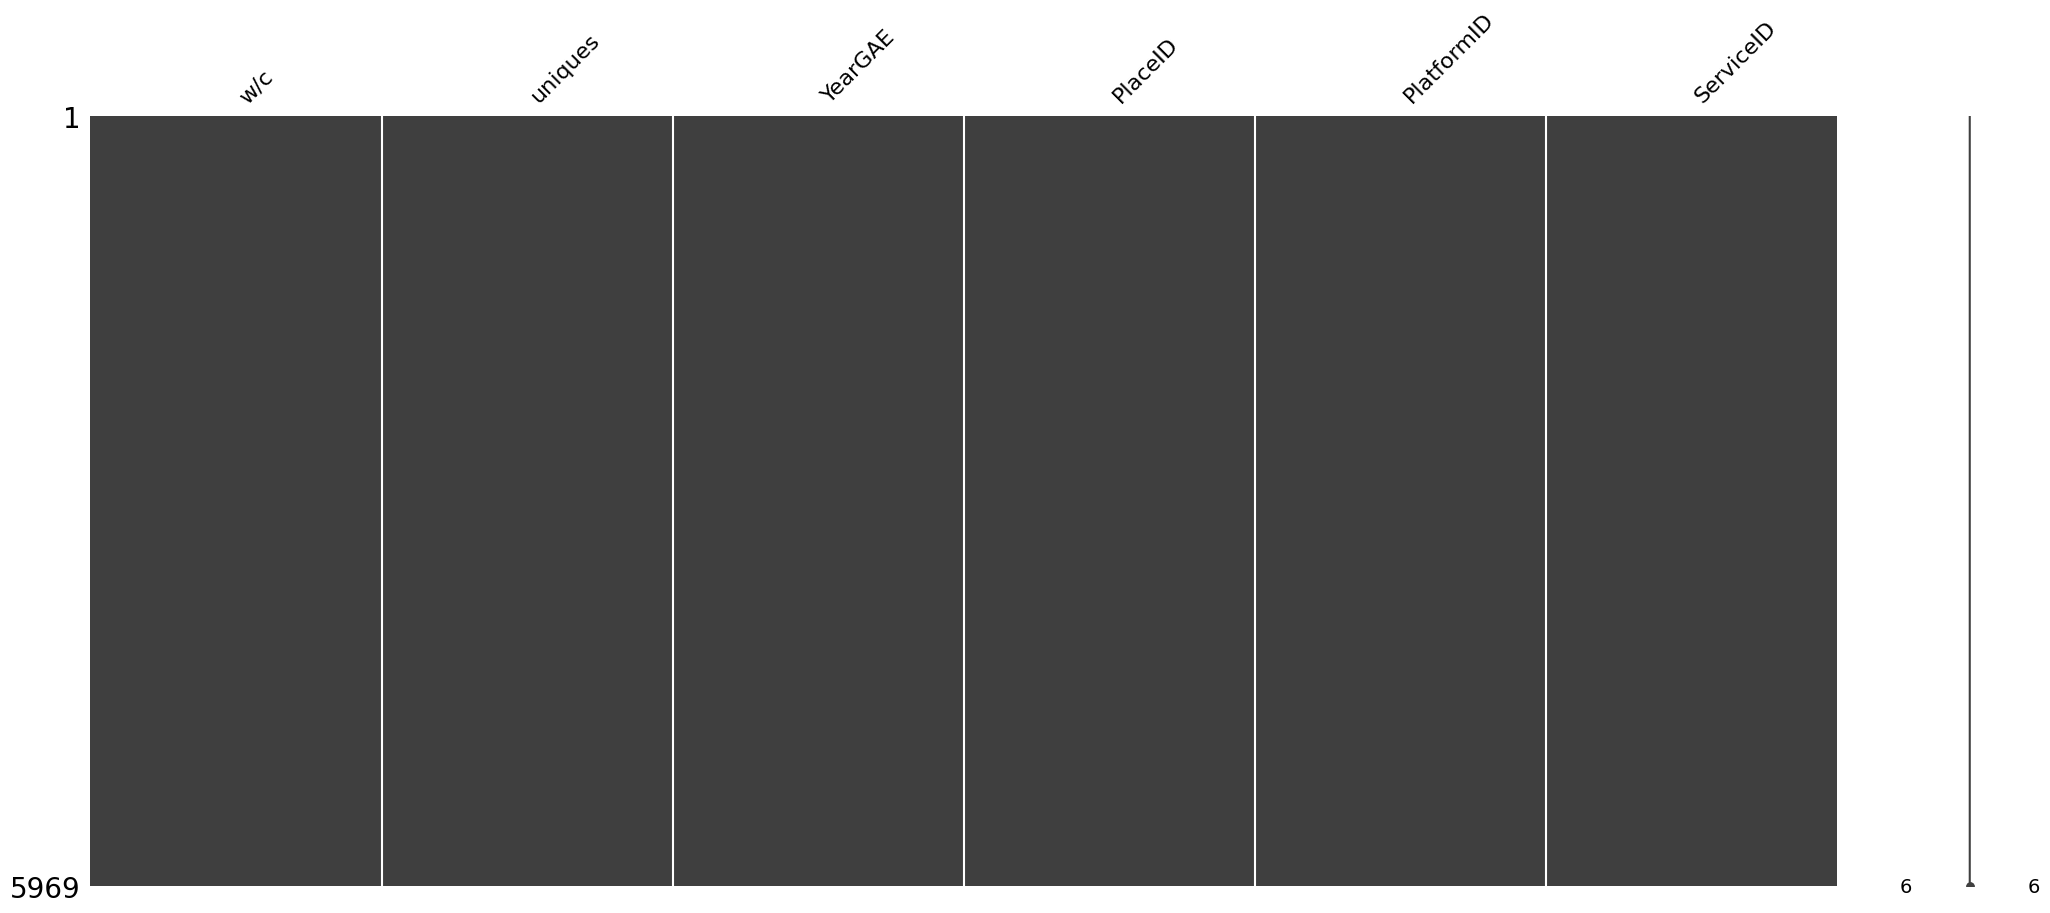

In [6]:
# TODO add this as automation next year 
cols = ['w/c', 'CBC_country', '[Listeners]']
ipo_data_cbc = pd.read_excel(f"../data/raw/podcast/CBC - {gam_info['file_timeinfo']}.xlsx", 
                             sheet_name="CBC")[cols]
ipo_data_cbc.rename(columns={'[Listeners]': 'uniques'}, inplace=True)
ipo_data_cbc['w/c'] = pd.to_datetime(ipo_data_cbc['w/c'])
display(ipo_data_cbc.sample())

################################# test syn data part I
# test & add weeks
print('..weeks:')
test_functions.test_weeks_presence('w/c', ipo_data_cbc, week_tester, '2_POD_4', test_step)
ipo_data_cbc = ipo_data_cbc.merge(week_tester, on='w/c', how='left')

# join to country_tester
print('..countries:')
cols = ['CBC_country', 'PlaceID']
test_functions.test_inner_join(ipo_data_cbc, country_codes[cols], ['CBC_country'], '2_POD_5', test_step, focus='left')
ipo_data_cbc = ipo_data_cbc.merge(country_codes[cols], on='CBC_country', how='left').drop(columns='CBC_country') #left because this test has run and I NEVER want to loose data

ipo_data_cbc['PlatformID'] = 'IPO'
ipo_data_cbc['ServiceID'] = 'WSE'

msno.matrix(ipo_data_cbc)

################################# add & test syn data part II
# add other excel 
ipo_data_2 = pd.read_excel(f"../data/raw/podcast/WSE_IPO_data_{gam_info['file_timeinfo']}.xlsx",)

# cross tab with week tester 
ipo_data_2 = ipo_data_2.merge(week_tester, on='YearGAE', how='left')
display(ipo_data_2.sample())
test_functions.test_weeks_presence('w/c', ipo_data_2, week_tester, '2_POD_6', test_step)

ipo_data = pd.concat([ipo_data_cbc, ipo_data_2])
msno.matrix(ipo_data)

################################# adding service parents to syn data I & II 
service_parents = ['ALL', 'ANW']

i = 7
for service in service_parents:
    test_number = f"2_POD_{i}"
    
    start = len(ipo_data)
    temp = ipo_data[ipo_data['ServiceID'] == 'WSE'].copy()
    test_val = len(temp)
    temp.loc[:, 'ServiceID'] = service
    print(f"{test_number}: {service}: {temp.shape}")
    ipo_data = pd.concat([ipo_data, temp])
    end = len(ipo_data)
    test_step = f"adding WSE to {service}"
    test_functions.test_adding_WWW(start, test_val, end, test_number, test_step=test_step, )
    i+=1

In [7]:
df = pd.concat([df, ipo_data])

In [8]:
################################# adding platforms
test_step = 'adding POD to IPO / DPO'
platform_list = ['DPO', 'IPO']
i = 12
for platform in platform_list:
    test_number = f"2_POD_{i}"
    
    # create Platform DPO from POD
    start = len(df)
    temp = df[df['PlatformID'] == platform].copy()
    test_val = len(temp)
    temp.loc[:, 'PlatformID'] = 'POD'
    print(f"{test_number}: {temp.shape}")
    df = pd.concat([df, temp])
    end = len(df)
    test_step = f"adding platform"
    test_functions.test_adding_WWW(start, test_val, end, test_number, test_step=test_step, )
    i +=1

2_POD_12: (113701, 6)
passed the test! 
...updating logbook...

2_POD_13: (17907, 6)
passed the test! 
...updating logbook...



In [9]:
df = df.groupby(['YearGAE', 'w/c', 'ServiceID', 'PlatformID', 'PlaceID'])['uniques'].sum().reset_index()

In [10]:
################################# adding services
service_creator = {
    
    'TOT': ['ANW'],
    'ANY': ['ANW'],
    'ENG': ['WSE', 'GNL', 'WOR'],
    'EN2': ['WSE', 'GNL'],   
}

i = 14
for service_id, service_children in service_creator.items():
    test_number = f"2_POD_{i}"
    
    start = len(df)
    print(f"{test_number}: {service_id}")
    temp = df[df['ServiceID'].isin(service_children)]
    temp = temp.groupby(['YearGAE', 'w/c', 'PlatformID', 'PlaceID'])['uniques'].sum().reset_index()
    test_val = len(temp)

    temp['ServiceID'] = service_id

    df = pd.concat([df, temp])
    end = len(df)

    test_step = f"adding higher services"
    test_functions.test_adding_WWW(start, test_val, end, test_number, test_step=test_step, )
    i += 1

2_POD_14: TOT
passed the test! 
...updating logbook...

2_POD_15: ANY
passed the test! 
...updating logbook...

2_POD_16: ENG
passed the test! 
...updating logbook...

2_POD_17: EN2
passed the test! 
...updating logbook...



In [11]:
df[df['PlatformID'].isna()]

,YearGAE,w/c,ServiceID,PlatformID,PlaceID,uniques


In [12]:

############################# TESTING start
main_df = df.copy()
test_step = 'final_testig_reachDF'

# test all weeks present
test_functions.test_weeks_presence_per_account('w/c', ['ServiceID'], main_df, week_tester, 
                                               '2_POD_16', test_step)

# test placeID in lookup
test_functions.test_inner_join(main_df, country_codes, ['PlaceID'], 
                               '2_POD_17', test_step, focus='left')

# test platformID in lookup
test_functions.test_inner_join(main_df, platform_codes, ['PlatformID'], 
                               '2_POD_18', test_step, focus='left')

# test serviceID in lookup
test_functions.test_inner_join(main_df, service_details, ['ServiceID'], 
                               '2_POD_19', test_step, focus='left')

# add a test of what platforms are expected to be part 

# add a test of what services are expected to be part 
############################# TESTING end


All weeks are present in the dataset for each group.
...updating logbook...

Inner join test 2_POD_17 successful: No issues found.
...updating logbook...

Inner join test 2_POD_18 successful: No issues found.
...updating logbook...

Inner join test 2_POD_19 successful: No issues found.
...updating logbook...



In [13]:
test_step = 'checking hierarchy for reach'
# SERVICE hierarchy issues
service_hierarchy_issues = test_functions.test_hierarchy_reach('2_POD_20', 
                                                               'Service', 
                                                               gam_info, 
                                                               df,
                                                               ['YearGAE', 'w/c', 'PlaceID', 'PlatformID'],
                                                               metric_col='uniques',
                                                               test_step=test_step)

# TODO share service hierarchy issues 

# PLATFORM hierarchy issues
platform_hierarchy_issues = test_functions.test_hierarchy_reach(test_number='2_POD_21', 
                                                                mode='Platform', 
                                                                gam_info=gam_info, 
                                                                df=df,
                                                                key=['YearGAE', 'w/c', 'PlaceID', 'ServiceID'],
                                                                metric_col='uniques',
                                                                test_step=test_step)

# TODO share Platform hierarchy issues 

...updating logbook...

All tests passed.
...updating logbook...

All tests passed.


# average weekly reach 

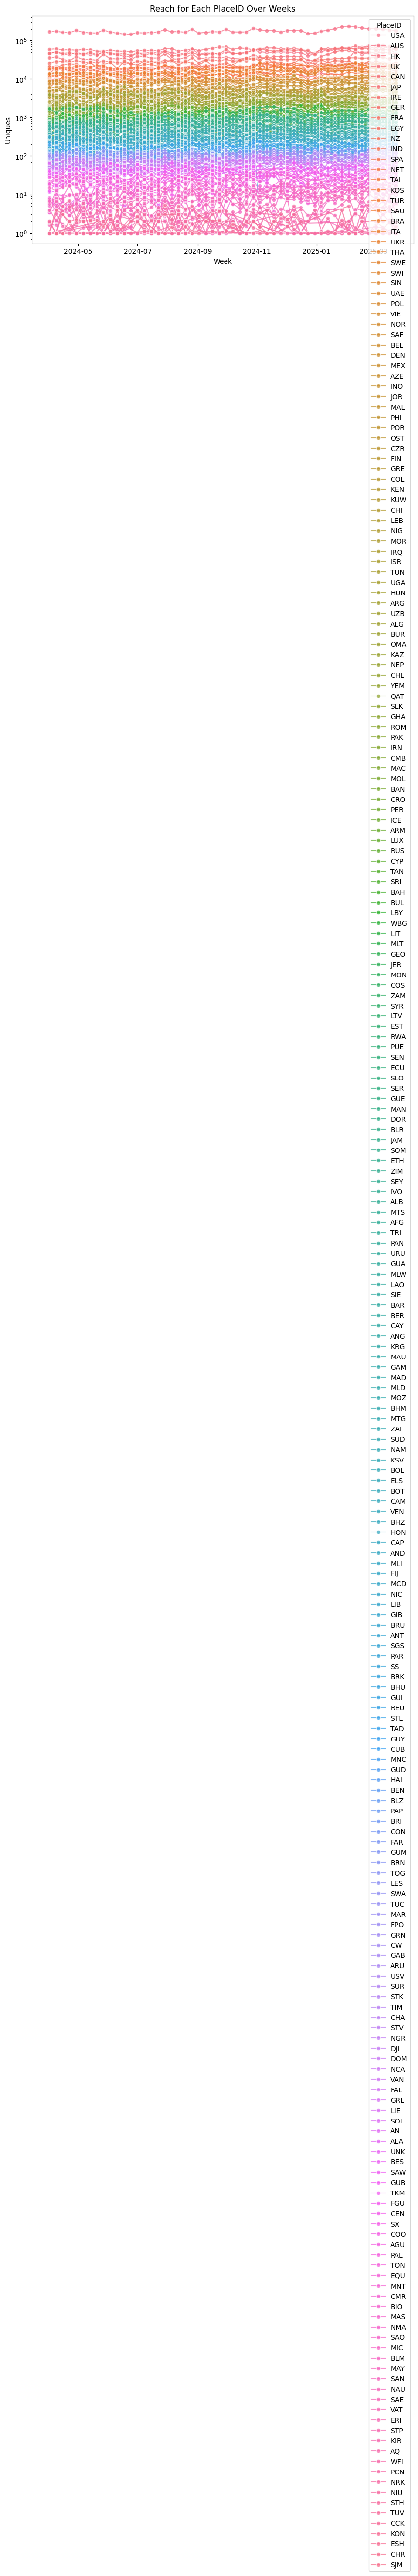

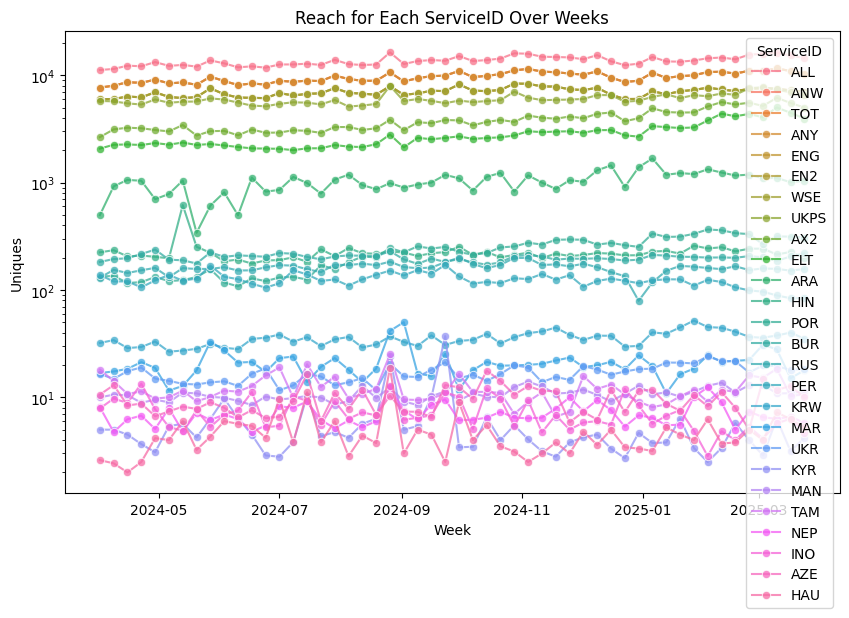

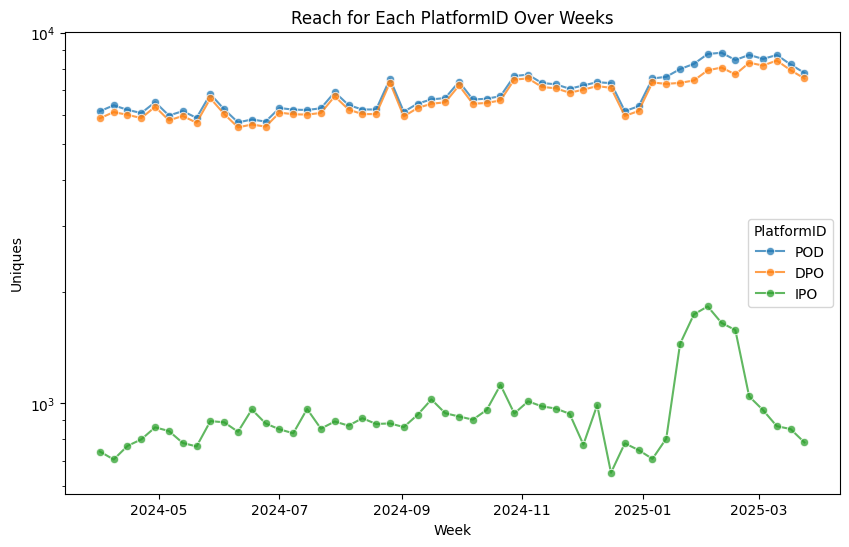

excluding entries that have no 0 values


In [14]:
test_functions.see_weekly_reach(gam_info, df.sort_values('uniques', ascending=False), 'PlaceID', 'podcast_weekly_country','w/c')
test_functions.see_weekly_reach(gam_info, df, 'ServiceID', 'podcast_weekly_service', 'w/c')
test_functions.see_weekly_reach(gam_info, df, 'PlatformID', 'podcast_weekly_platform', 'w/c')
test_functions.see_weekly_reach(gam_info, df, 'PlaceID', 'podcast_weekly_country', 'w/c', with_nonNull_filter=True, subset=True, store=True)


In [15]:
df.to_excel(f"../data/singlePlatform/output/weekly/{gam_info['file_timeinfo']}_podcast_data_weekly.xlsx", index=None)

final_df = df.groupby(['ServiceID', 'PlatformID', 'PlaceID'])['uniques'].sum().reset_index(name='Reach')
final_df['Reach'] = final_df['Reach'] / gam_info['number_of_weeks']

final_df.to_excel(f"../data/singlePlatform/output/{gam_info['file_timeinfo']}_podcast_reach_annual.xlsx", index=None)